In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from pathlib import Path

In [13]:
train_dir = Path('data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [14]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [15]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['tomato' 'carrot' 'corn' 'pear' 'onion' 'potato' 'peas' 'watermelon'
 'ginger' 'lettuce' 'chilli pepper' 'cucumber' 'lemon' 'garlic'
 'pineapple' 'spinach' 'sweetcorn' 'kiwi' 'apple' 'mango' 'jalepeno'
 'grapes' 'turnip' 'bell pepper' 'paprika' 'pomegranate' 'cabbage'
 'eggplant' 'soy beans' 'orange' 'cauliflower' 'capsicum' 'raddish'
 'beetroot' 'sweetpotato' 'banana']


In [16]:
train_df.head(5)

,Filepath,Label
0,data\train\tomato\Image_45.jpg,tomato
1,data\train\carrot\Image_13.jpg,carrot
2,data\train\corn\Image_52.jpg,corn
3,data\train\pear\Image_21.jpg,pear
4,data\train\onion\Image_82.jpg,onion


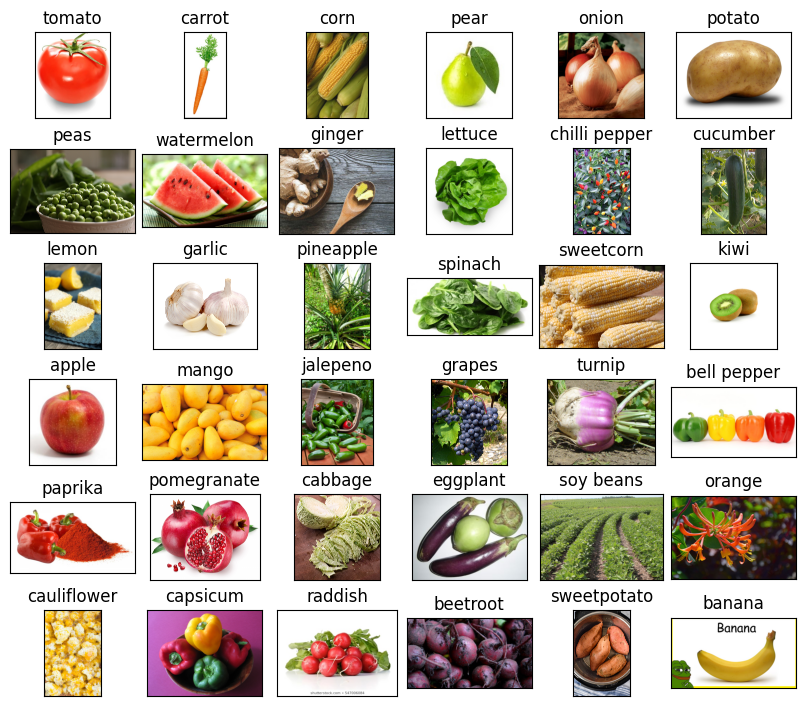

In [17]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [18]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.


In [32]:
pretrained_model1 = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model1.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 4s 1us/step


In [37]:
inputs = pretrained_model1.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model1.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.2777 - loss: 2.8739 - val_accuracy: 0.7853 - val_loss: 0.7273
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 91s 962ms/step - accuracy: 0.7528 - loss: 0.8387 - val_accuracy: 0.8794 - val_loss: 0.4121
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 90s 951ms/step - accuracy: 0.8271 - loss: 0.5811 - val_accuracy: 0.8971 - val_loss: 0.3244
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 92s 967ms/step - accuracy: 0.8863 - loss: 0.4036 - val_accuracy: 0.8941 - val_loss: 0.3377
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 89s 950ms/step - accuracy: 0.8870 - loss: 0.3432 - val_accuracy: 0.8941 - val_loss: 0.2879
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 93s 981ms/step - accuracy: 0.9187 - loss: 0.2691 - val_accuracy: 0.9324 - val_loss: 0.2472
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 90s 954ms/step - accuracy: 0.9383 - loss: 0.2200 - val_accuracy: 0.9265 - val_loss: 0.2456
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 91s 956ms/step - accuracy: 0.9467 - loss: 0.1874 - val_accura

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

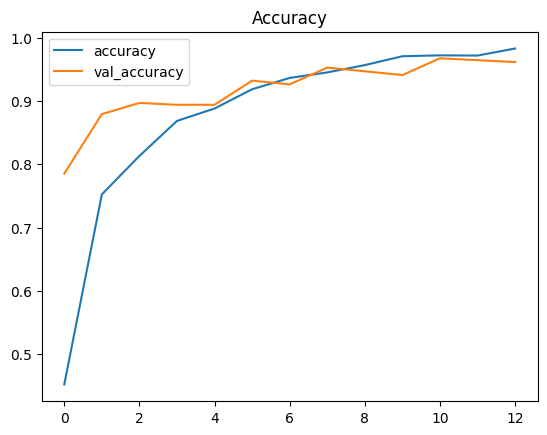

In [38]:
pd.DataFrame(history1.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

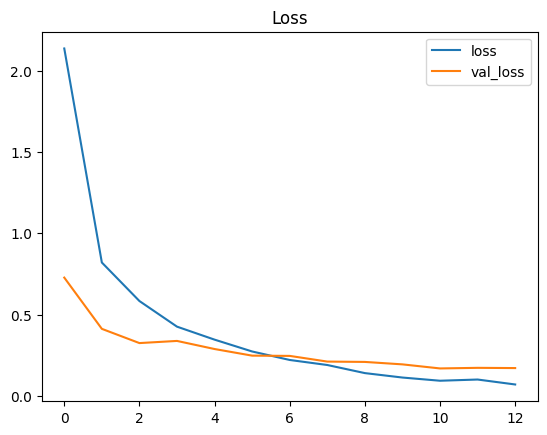

In [39]:
pd.DataFrame(history1.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy: 0.9676


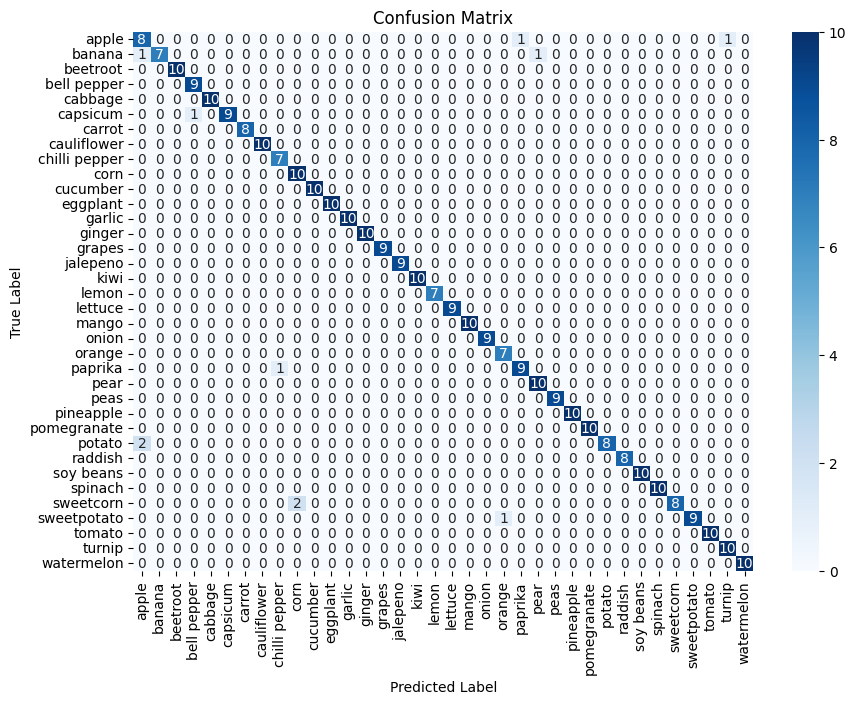

Classification Report:
               precision    recall  f1-score   support

        apple       0.73      0.80      0.76        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.90      1.00      0.95         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.90      0.95        10
       carrot       1.00      1.00      1.00         8
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.88      1.00      0.93         7
         corn       0.83      1.00      0.91        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00         9
         kiwi       1.00      1.00      1

In [42]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the labels
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Get the true labels for test images
true_labels = [labels[k] for k in test_images.classes]

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred, labels=list(labels.values()))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred, target_names=labels.values()))

In [57]:
from tensorflow.keras.models import load_model
model.save('predictfruit.keras')


loaded_model = load_model('predictfruit.keras')


c:\Users\PAWAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [59]:
from tensorflow.keras.preprocessing import image

In [60]:
# Path to the image you want to predict
image_path = 'test.png'

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)  # Preprocess the image

# Make prediction
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Map the label indices to class names
class_indices = {v: k for k, v in train_images.class_indices.items()}
predicted_label = class_indices[predicted_class[0]]

print(f'Predicted label: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: apple
